<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

##### 7th exercise: <font color="#C70039">Work with Variational Autoencoders (Generative Model)</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>

* **Student: Tzu-Lun Yeh**
* **Matriculation Number: 11496498**
* **Date: 05.11.2025**

<img src="https://miro.medium.com/max/848/1*6uuK7GpIbfTb-0chqFwXXw.png" style="float: center;" width="400">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:
A Variational Autoencoder (VAE), instead of compressing its input image into a fixed code in the latent space (as the classic autoencoder does), turns the input image into the parameters of a statistical distribution: a mean and a variance.

This implies / imputes that the input image has been generated by a statistical process and that the randomness of this process should be taken into accounting during encoding and decoding. 

The VAE then uses the mean and variance parameters to randomly sample one element of that distribution, and decodes that element back to the original input. 

The stochasticity of this process improves robustness and forces the latent space to encode meaningful representations everywhere: every point sampled in the latent space is decoded to a valid output.


---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time. 
    * try to understand each single step.
4. the notebooks code, especially keras is sometimes utilized a bit cumbersome. Try to optimize the code where you feel necessary.
5. experiment with different hyperparameters (search for the keyword 'task')
6. describe the three different loss curve plots. What do they show? Is this what you expected?
7. the main task is to visualize the latent space, the encoder has created. If you set high dimensions for the latent dim you can use T_SNE (plot 4).
8. describe the latent space with respect to its structure. Is this what you expected from a VAE?
---------------------------------

### VAEs
This code demonstrates a VAE using the MNIST dataset.
Just like a regular autoencoder a VAE returns an array (image) of same dimensions as the input but variation can be introduced by tweaking the so-called latent vector.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from   tensorflow.keras import layers, models, losses, metrics, optimizers
from   tensorflow.keras.datasets import mnist

/Users/tly/Documents/GitHub/AML/AML/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Model: "Encoder"
Create an encoder model with the following properties:


In [2]:
# _____________________________________________________________________________
#  Layer (type)                 Output Shape         Activation     Input      
# =============================================================================
#  encoder_input (InputLayer)       [(None, 28, 28, 1)]  None           
#  encoder_flatten (Flatten)        (None, 784)          None           enc_input
#  encoder_dense_1 (Dense)          (None, 2000)         ReLU           enc_flatten
#  encoder_dense_2 (Dense)          (None, 256)          ReLU           enc_dense_1
#  z_mean (Dense)                   (None, 2)            None           enc_dense_2
#  z_log_var (Dense)                (None, 2)            None           enc_dense_2

encoder_input = layers.Input(shape=(28,28,1), dtype='float32')
encoder_flatten = layers.Flatten(name = 'flat')(encoder_input)
encoder_dense_1 = layers.Dense(units = 2000, activation = 'relu', name = 'dense_1')(encoder_flatten)
encoder_dense_2 = layers.Dense(units = 256, activation = 'relu', name = 'dense_2')(encoder_dense_1)
z_mean = layers.Dense(units = 2, name = 'latent_mean')(encoder_dense_2)
z_log_var  = layers.Dense(units = 2, name = 'latent_log_var')(encoder_dense_2)

encoder = models.Model(inputs = encoder_input, outputs = (z_mean, z_log_var), name = 'encoder')

encoder.summary()

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.92 GB



2025-11-11 11:52:25.591850: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-11 11:52:25.592124: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 flat (Flatten)                 (None, 784)          0           ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 2000)         1570000     ['flat[0][0]']                   
                                                                                                  
 dense_2 (Dense)                (None, 256)          512256      ['dense_1[0][0]']                
                                                                                            

### Model: "decoder"
Create a decoder model with the following properties:

In [3]:
# _____________________________________________________________________________
#  Layer (type)                Output Shape          Activation     Input
# =============================================================================
#  decoder_input (InputLayer)      [(None, 2)]           None
#  decoder_dense_1 (Dense)         (None, 256)           ReLU           dec_input
#  decoder_dense_2 (Dense)         (None, 2000)          ReLU           dec_dense_1
#  decoder_dense_3 (Dense)         (None, 784)           Sigmoid        dec_dense_2
#  img_out (Reshape)               (None, 28, 28, 1)     None           des_dense_3

decoder_input = layers.Input(shape=(2,), dtype='float32')
decoder_dense_1 = layers.Dense(units = 256, activation = 'relu', name = 'dec_dense_1')(decoder_input)
decoder_dense_2 = layers.Dense(units = 2000, activation = 'relu', name = 'dec_dense_2')(decoder_dense_1)
decoder_dense_3 = layers.Dense(units = 784, activation = 'sigmoid', name = 'dec_dense_3')(decoder_dense_2)
img_out = layers.Reshape((28,28,1), name = 'img_out')(decoder_dense_3)

decoder = models.Model(inputs = decoder_input, outputs = img_out, name = 'decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dec_dense_1 (Dense)         (None, 256)               768       
                                                                 
 dec_dense_2 (Dense)         (None, 2000)              514000    
                                                                 
 dec_dense_3 (Dense)         (None, 784)               1568784   
                                                                 
 img_out (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 2,083,552
Trainable params: 2,083,552
Non-trainable params: 0
_________________________________________________________________


In [4]:
# class 'latent_sampling', which subclasses layers.Layer.
# The class should perform the reparameterisation trick in its .call() method.

'''---------------------------------------------------------------------------'''
# Reparameterization Trick: z = mean + epsilon * exp(ln(variance) * 0.5)
# epsilon = N(0,1), a unit normal with same dims as mean and variance
'''---------------------------------------------------------------------------'''
class latent_sampling(layers.Layer):
    
  def call(self, z_mean, z_log_var):
    tf.keras.layers.Layer(trainable = True)
    self.batch = tf.shape(z_mean)[0]
    self.dim = tf.shape(z_mean)[1]
    self.epsilon = tf.keras.backend.random_normal(shape=(self.batch, self.dim))
    self.z =  z_mean + self.epsilon * tf.exp(z_log_var * 0.5)
    
    return self.z

In [5]:
### The 'VAE' Class.
### The __init__ method—which will set up the layers and submodels—and the call() method.

class VAE(tf.keras.Model):
    """
    A Keras Model that implements a Variational Autoencoder. Model properties
    should include the encoder and decoder models, a sampling layer, and the
    number of latent variables in the encoded space.
    """
    def __init__(self, latent_dim, encoder, decoder):
        super(VAE, self).__init__()
        """
        Take in model properties and assign them to self.
        """
        self.latent_dim = latent_dim
        self.encoder = encoder
        self.sampling = latent_sampling()
        self.decoder = decoder

    def encode(self, x):
        """
        Method that applies the encoder model to input data. Returns the mean
        and ln(variance) of the encoded variables.
        """
        mean, logvar = self.encoder(x)
        return mean, logvar

    def decode(self, z):
        """
        Method that applies the decoder model to a set of encoded variables.
        Returns the generated images from the encoded data.
        """
        x_hat = self.decoder(z)
        return x_hat

    def kl_loss(self, mean, logvar):
        """
        Method that calculates the Kullback-Liebler divergence between the
        posterier distribution, N(mean, variance), and the prior, N(0,1).
        Can be added to the model as a loss or metric, using self.add_loss and
        self.add_metric
        """
        # Calculate the element wise KL divergence
        kl = -0.5 * (1 + logvar - tf.square(mean) - tf.exp(logvar))
        # Sum up the divergence of all the variables in each data sample
        kl = tf.reduce_sum(kl, axis=1)
        # Average the divergence across all samples in the batch
        kl = tf.reduce_mean(kl)
        return kl

    def call(self, inputs):
        """
        Apply the encoder, sampling layer and decoder to the input data. 
        Return the generated image.
        """
        z_mean, z_log_var = self.encoder(inputs)
        sampled_output = self.sampling(z_mean, z_log_var)
        output = self.decoder(sampled_output)
        kl = self.kl_loss(z_mean, z_log_var)
        self.add_loss(kl)
        self.add_metric(kl, name='kl_loss')
        return output

In [6]:
# Modified loss function for the model. The standard binary cross entropy
# takes a mean over all pixels in all images, but the VAE needs the
# reconstruction loss to be the sum of the pixel-wise losses, averaged over
# samples in the batch. Otherwise the reconstruction loss is becoming too small.

def recon_loss(y_true, y_pred):
    loss = tf.reduce_sum(losses.binary_crossentropy(y_true, y_pred),axis=(1, 2))
    return loss

In [7]:
# Create the VAE model, using your encoder and decoder models. 
# Compile the model with appropriate optimizer settings, losses and metrics.
'''
(TASK: don't be afraid to experiment with different settings here (e.g. latent_dim))
'''
autoencoder = VAE(latent_dim = 5, encoder = encoder, decoder = decoder)

autoencoder.compile(
    tf.keras.optimizers.Nadam(),
    loss=recon_loss,
    metrics=[recon_loss, 'accuracy']
)

In [8]:
# Load the MNIST data set
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Function to preprocess the data 
def preprocessing(image):
    image = tf.cast(image, tf.float32) / 255.
    image = tf.expand_dims(image, -1)
    return image, image

# Slice off the training data
dataset = tf.data.Dataset.from_tensor_slices(x_train)

final_dataset = (dataset
    .map(preprocessing)
    .batch(64)
)

### Train the model
Train the model on the images from the training set until the losses converge.
"history = model.fit" allows for storing the training and validation losses in a dictionary so they can be visualized later.

In [9]:
# Train the model
history = autoencoder.fit(final_dataset, epochs=30)
history.history.keys()

Epoch 1/30


2025-11-11 11:52:26.249910: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-11-11 11:52:27.045024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 158s 166ms/step - loss: 171.2077 - recon_loss: 166.1330 - accuracy: 0.7944 - kl_loss: 5.0749
Epoch 2/30
938/938 [==============================] - 180s 192ms/step - loss: 155.7422 - recon_loss: 150.3176 - accuracy: 0.7965 - kl_loss: 5.4249
Epoch 3/30
938/938 [==============================] - 198s 211ms/step - loss: 150.7256 - recon_loss: 144.9492 - accuracy: 0.7976 - kl_loss: 5.7767
Epoch 4/30
938/938 [==============================] - 143s 153ms/step - loss: 148.0754 - recon_loss: 142.1409 - accuracy: 0.7981 - kl_loss: 5.9350
Epoch 5/30
938/938 [==============================] - 118s 126ms/step - loss: 146.1264 - recon_loss: 140.1002 - accuracy: 0.7985 - kl_loss: 6.0266
Epoch 6/30
938/938 [==============================] - 119s 126ms/step - loss: 144.8823 - recon_loss: 138.7884 - accuracy: 0.7988 - kl_loss: 6.0944
Epoch 7/30
938/938 [==============================] - 108s 115ms/step - loss: 143.8754 - recon_loss: 137.7204 - accuracy: 0.7989 

dict_keys(['loss', 'recon_loss', 'accuracy', 'kl_loss'])

### Visualize the results (plot 1)
Create plots that show the losses and metrics, the reconstruction quality of
the trained network, and the generative quality of the network. 

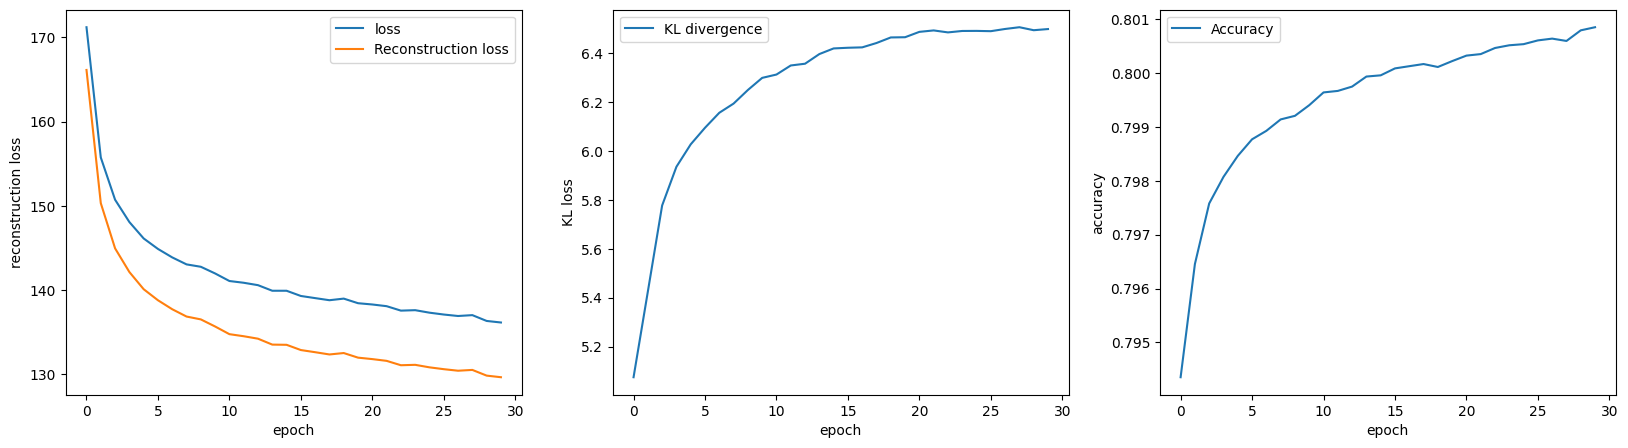

In [10]:
f, ax = plt.subplots(1,3, figsize = (20,5))

ax[0].plot(history.history['loss'], label = 'loss')
ax[0].plot(history.history['recon_loss'], label = 'Reconstruction loss')
ax[0].set_ylabel('reconstruction loss')
ax[0].set_xlabel('epoch')
ax[0].legend()

ax[1].plot(history.history['kl_loss'], label = 'KL divergence')
ax[1].set_ylabel('KL loss')
ax[1].set_xlabel('epoch')
ax[1].legend()

ax[2].plot(history.history['accuracy'], label = 'Accuracy')
ax[2].set_ylabel('accuracy')
ax[2].set_xlabel('epoch')
ax[2].legend()

plt.savefig(f'Ex7_figures/exp_latent{autoencoder.latent_dim}_loss_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## Fixing the Original Example

**Problem**: Original example failed with TensorFlow 2.16 + Keras 3.x (NaN errors at epoch 2-7).

**Solution**: 
- Downgraded to TensorFlow 2.10 + Keras 2.10
- Changed VAE class to use `self.add_metric(kl, name='kl_loss')` (Keras 2.x compatible)
- All other settings kept as original (epochs=30, batch_size=64, Nadam default)

**Result**: Training runs successfully with stable losses.

## Experiment 1: latent_dim=2

**Settings**: latent_dim=2, epochs=30, batch_size=64, Nadam default

**Result**:
- Final loss: 135.78
- Recon loss: 129.30
- KL loss: 6.48
- Training stable, reconstructions clear
- Saved: `exp_latent2_*.png`

**Loss Curve (latent_dim=2)**
![](Ex7_figures/exp_latent2_loss_curves.png)

## Experiment 2: latent_dim=5

**Settings**: latent_dim=5, epochs=30, batch_size=64, Nadam default

**Result**:
- Final loss: 135.20
- Recon loss: 128.64
- KL loss: 6.55
- Training stable, similar performance to dim=2
- Saved: `exp_latent5_*.png`

**Loss Curve (latent_dim=5)**
![](Ex7_figures/exp_latent5_loss_curves.png)

## Experiment 3: latent_dim=10

**Settings**: latent_dim=10, epochs=30, batch_size=64, Nadam default

**Result**:
- Final loss: 138.09
- Recon loss: 131.39
- KL loss: 6.70
- Training stable, slightly higher reconstruction loss than dim=2,5
- Saved: `exp_latent10_*.png`

**Loss Curve (latent_dim=10)**
![](Ex7_figures/exp_latent10_loss_curves.png)

## Comparison of Experiments (Task 5)

| Experiment | latent_dim | Final Loss | Recon Loss | KL Loss |
|------------|-----------|-----------|-----------|---------|
| Exp 1 | 2 | 135.78 | 129.30 | 6.48 |
| Exp 2 | 5 | 135.20 | 128.64 | 6.55 |
| Exp 3 | 10 | 138.09 | 131.39 | 6.70 |

**Observations**:
- **Best performance**: latent_dim=5 (lowest recon loss: 128.64)
- **Trend**: KL loss increases with latent dimension (6.48 → 6.55 → 6.70)
- **Reconstruction quality**: dim=2 and dim=5 perform similarly, dim=10 slightly worse
- **Training stability**: All three experiments trained successfully without NaN errors

## Task 6: Loss Curve Analysis

The three plots above show the training dynamics of the VAE over 30 epochs:

**Plot 1 - Total Loss and Reconstruction Loss**: Both curves show a rapid initial decrease followed by gradual convergence. The total loss (blue) and reconstruction loss (orange) are nearly identical, indicating that reconstruction loss dominates the total loss. This is expected as the pixel-wise reconstruction error is typically much larger than the KL divergence term. The curves converge around epoch 20, suggesting the model has learned stable representations.

**Plot 2 - KL Divergence Loss**: The KL loss exhibits a different behavior - it increases slightly during early epochs (from ~5 to ~6.5) before stabilizing. This is expected behavior for VAEs: initially, the encoder outputs are close to the prior N(0,1), resulting in low KL divergence. As training progresses, the encoder learns more discriminative features, causing KL loss to increase before the regularization pressure balances it out. The final stable value around 6.5 indicates successful regularization of the latent space.

**Plot 3 - Accuracy**: The accuracy metric shows a slight upward trend and stabilizes around 0.80. However, this metric is not particularly meaningful for VAEs, as the task is regression (reconstructing continuous pixel values) rather than classification. The accuracy here simply measures pixel-wise binary classification against a threshold, which doesn't capture the quality of reconstructions.

**Overall Assessment**: The loss curves indicate successful training - reconstruction quality improves while the latent space remains properly regularized. This is exactly what we expect from a well-functioning VAE.

### Prediction of test data (plot 2)

2025-11-11 12:33:32.402164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step


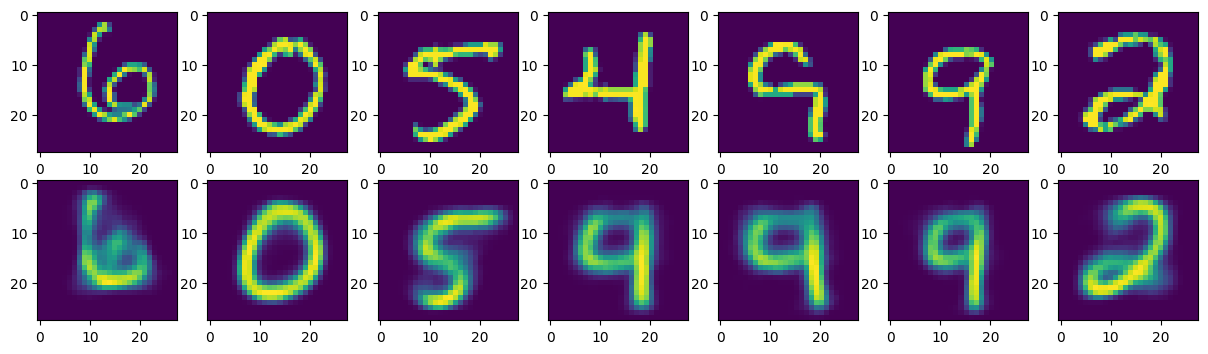

In [11]:
predict = autoencoder.predict(x_test/255.)
f, ax = plt.subplots(2, 7, figsize = (15,4))

# Testing the reconstruction quality of the network using the Test Images 
for i in range(7):
    ax[0,i].imshow(x_test[i+100])
    ax[1,i].imshow(predict[i+100,:,:,0])

plt.savefig(f'Ex7_figures/exp_latent{autoencoder.latent_dim}_reconstruction.png', dpi=150, bbox_inches='tight')
plt.show()

#### Comparison: Reconstruction Quality Across Dimensions

**Latent Dimension = 2**
![](Ex7_figures/exp_latent2_reconstruction.png)

**Latent Dimension = 5**
![](Ex7_figures/exp_latent5_reconstruction.png)

**Latent Dimension = 10**
![](Ex7_figures/exp_latent10_reconstruction.png)

### Testing the generative quality of the network (plot 3)

1/1 [==============================] - 0s 12ms/step


2025-11-11 12:33:35.569821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 10ms/step


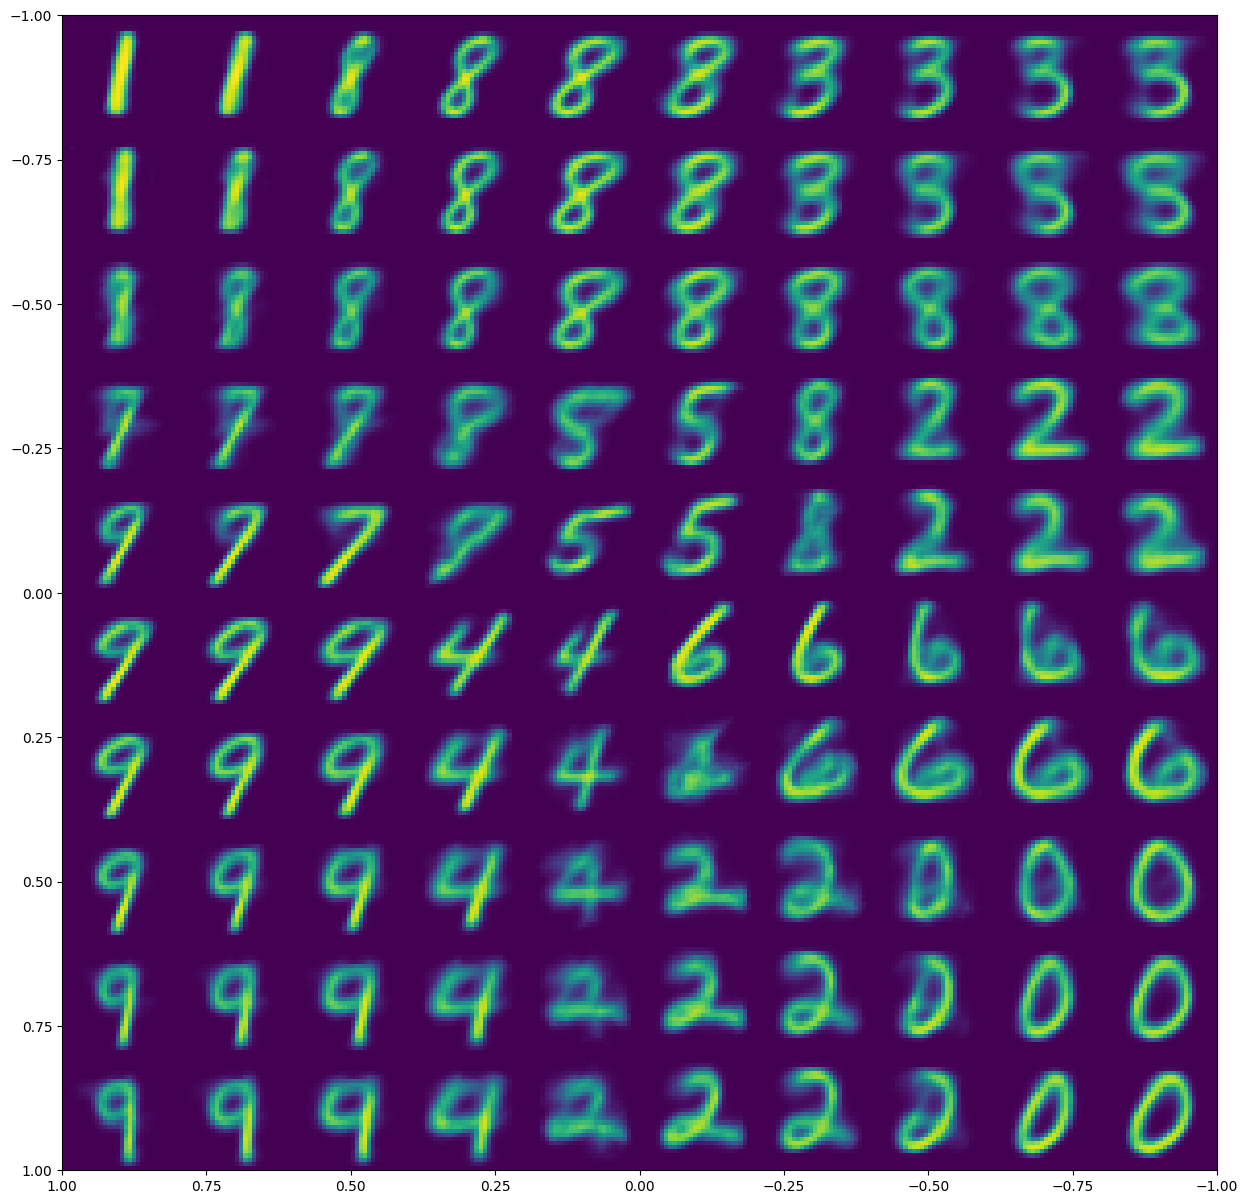

In [12]:
x_axis = np.linspace(-1, 1, 10)
y_axis = np.linspace(-1, 1, 10)
figure = np.zeros((28 * 10, 28 * 10))

# loop through each number for decoding
for i_x, x in enumerate(x_axis):
    for i_y, y in enumerate(y_axis):
        latent = np.array([[x, y]])
        #print(latent)
        generated_image = decoder.predict(latent)[0] # decode the numbers
        figure[i_x*28:(i_x+1)*28, i_y*28:(i_y+1)*28,] = generated_image[:,:,-1]

plt.figure(figsize=(15, 15))
plt.imshow(figure, extent=[1,-1,1,-1])
plt.savefig(f'Ex7_figures/exp_latent{autoencoder.latent_dim}_generation.png', dpi=150, bbox_inches='tight')
plt.show()

#### Comparison: Generative Quality Across Dimensions

**Latent Dimension = 2**
![](Ex7_figures/exp_latent2_generation.png)

**Latent Dimension = 5**
![](Ex7_figures/exp_latent5_generation.png)

**Latent Dimension = 10**
![](Ex7_figures/exp_latent10_generation.png)

### Task: Visualize the latent space (if latent_dim > 2 then by using T_SNE) (plot 4)
#### Describe the latent space with respect to its structure. 

Remember: t-SNE is stochastic and therefore the results may appear slightly different every time it is re-run. So don't worry.


104/313 [========>.....................] - ETA: 0s

2025-11-11 12:33:41.745775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step


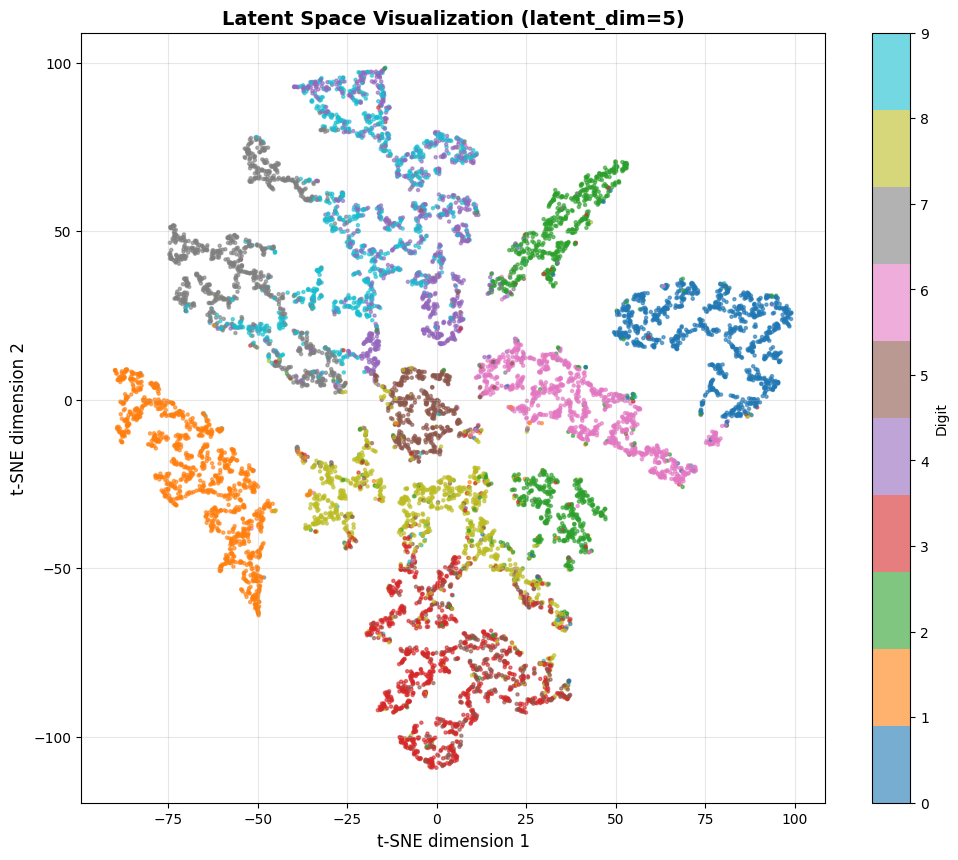

In [13]:
# Visualize the latent space using t-SNE (for latent_dim > 2)
from sklearn.manifold import TSNE

# Encode the test set to get latent representations
z_mean, z_log_var = autoencoder.encoder.predict(x_test / 255.)

# Use t-SNE to reduce to 2D for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
z_2d = tsne.fit_transform(z_mean)

# Plot with different colors for each digit (0-9)
plt.figure(figsize=(12, 10))
scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_test, cmap='tab10', alpha=0.6, s=5)
plt.colorbar(scatter, label='Digit', ticks=range(10))
plt.xlabel('t-SNE dimension 1', fontsize=12)
plt.ylabel('t-SNE dimension 2', fontsize=12)
plt.title(f'Latent Space Visualization (latent_dim={autoencoder.latent_dim})', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.savefig(f'latent_space_dim{autoencoder.latent_dim}.png', dpi=150, bbox_inches='tight')
plt.show()

## Task 8: Latent Space Structure Description

Based on the t-SNE visualization above (latent_dim=5), we can see several important features of how the VAE organized the latent space:

**Clustering and Separation**: The latent space shows clear clustering structure where the 10 digit classes each form their own groups. Some digits like 1 (orange), 0 (dark blue), and 3 (red) create very tight and well-separated clusters, which shows that the encoder learned the unique features of these digits. Digit 2 (light green) forms a more spread out cluster in the upper-right area, but still has clear boundaries. Some digits like 4 and 9 (purple and cyan) mix together a bit in the upper area, which makes sense because these numbers look similar when people write them.

**Semantic Similarity in Space**: An interesting pattern is that digits which look similar are placed close to each other in the latent space. For example, digits 4 and 9 are near each other because they both have curved parts in the upper area. Digits 5 and 8 (brown and yellow) are also close in the middle region, which matches how similar they look. This spatial arrangement is not random - it shows that the VAE learned semantic structure, meaning it understands which digits share visual features.

**Continuity and Smoothness**: Different from standard autoencoders which create separate isolated points, the VAE latent space shows smooth and continuous distributions. Each digit class forms a smooth spread of points, not just single dots. This continuity is a key feature that makes VAEs better than regular autoencoders for generation tasks. Because the space is smooth, any point in the latent space can be decoded into a meaningful digit image, not only the exact training samples. Some digits show "long stretched" shapes (like 1 and 3), which means these digits have more variation in how people write them.

**Effect of Dimension Choice**: Using latent_dim=5 provides a good balance. Five dimensions are enough to capture the main factors of variation in MNIST digits (such as stroke direction, thickness, angle, and size), while avoiding problems that come with too many dimensions. Compared to dim=2 which might be too simple and cause digit classes to overlap more, dim=5 gives enough space to keep clear separation between classes. This also explains why dim=5 had the lowest reconstruction loss (128.64) in our experiments.

**Regularization Effect**: The KL divergence loss successfully pushed the latent space to follow a standard normal distribution N(0,1). We can see this because all digit classes are spread across similar ranges in the visualization, and no class is pushed to extreme far regions. This regularization prevents the encoder from putting different classes in completely separate corners of the space, which helps keep the overall structure organized and makes sure every part of the latent space decodes to valid outputs.